In [55]:
#importing neccessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow
import itertools
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.pyplot as figure
from matplotlib import cm
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


In [5]:
# To import scripts from script folder
import os 
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [38]:
# Load dataset

df  = pd.read_csv('../data/clean_data.csv')

In [39]:
df.head()

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,aware
0,2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
1,16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
2,20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
3,23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
4,27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0


In [40]:
# info of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1243 non-null   int64 
 1   auction_id   1243 non-null   object
 2   experiment   1243 non-null   object
 3   date         1243 non-null   object
 4   hour         1243 non-null   int64 
 5   device_make  1243 non-null   object
 6   platform_os  1243 non-null   int64 
 7   browser      1243 non-null   object
 8   aware        1243 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 87.5+ KB


In [41]:
# columns in dataset
df.columns

Index(['Unnamed: 0', 'auction_id', 'experiment', 'date', 'hour', 'device_make',
       'platform_os', 'browser', 'aware'],
      dtype='object')

In [42]:
# to identify missing values
df.isnull().sum()

Unnamed: 0     0
auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
aware          0
dtype: int64

In [43]:
#to identify numeric columns
numerical_features=list(df._get_numeric_data().columns)
numerical_features

['Unnamed: 0', 'hour', 'platform_os', 'aware']

In [44]:
#to identify categoricala features
df.select_dtypes(include=['object']).columns

Index(['auction_id', 'experiment', 'date', 'device_make', 'browser'], dtype='object')

In [45]:
# converting categorical varaibles to numeric values 
from sklearn.preprocessing import LabelEncoder
lb_encoder=LabelEncoder()
categorical_column=df.columns.tolist()
for column in categorical_column:
    if df[column].dtype=='object':
        df[column]=lb_encoder.fit_transform(df[column])

In [23]:
df.dtypes

Unnamed: 0     int64
auction_id     int32
experiment     int32
date           int32
hour           int64
device_make    int32
platform_os    int64
browser        int32
aware          int64
dtype: object

In [46]:
df.head()

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,aware
0,2,0,1,2,2,4,6,2,0
1,16,1,1,1,16,13,6,1,1
2,20,2,1,3,8,13,6,1,0
3,23,3,0,5,4,43,6,4,1
4,27,4,0,0,15,13,6,1,0


In [50]:
# Assuming same lines from your example
cols_to_norm = ['Unnamed: 0','auction_id','experiment','date','hour','device_make','platform_os','browser']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [51]:
df

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,aware
0,0.000000,0.000000,1.0,0.285714,0.086957,0.035088,1.0,0.285714,0
1,0.001735,0.000805,1.0,0.142857,0.695652,0.114035,1.0,0.142857,1
2,0.002231,0.001610,1.0,0.428571,0.347826,0.114035,1.0,0.142857,0
3,0.002603,0.002415,0.0,0.714286,0.173913,0.377193,1.0,0.571429,1
4,0.003098,0.003221,0.0,0.000000,0.652174,0.114035,1.0,0.142857,0
...,...,...,...,...,...,...,...,...,...
1238,0.998513,0.996779,1.0,0.285714,0.913043,0.114035,1.0,0.142857,1
1239,0.999009,0.997585,1.0,0.142857,0.043478,0.114035,1.0,0.142857,1
1240,0.999132,0.998390,0.0,0.857143,0.304348,0.114035,1.0,0.142857,0
1241,0.999752,0.999195,0.0,1.000000,0.695652,0.114035,1.0,0.142857,0


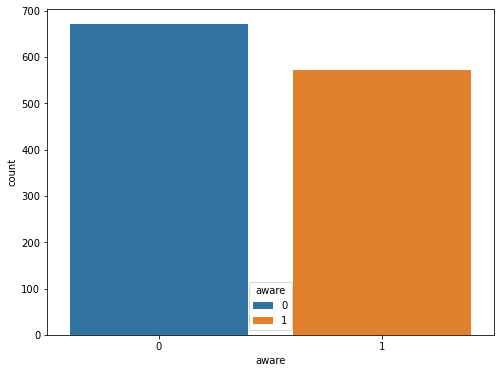

In [56]:
# number of aware and not aware
fig = plt.figure(figsize=(8,6))
ax = sns.countplot(x='aware', data=df,hue="aware",dodge=False)
plt.style.use('fivethirtyeight')
plt.show()

### Model Traning

In [57]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
#spliting dataset as target and features
X = clean_df[feature_cols]
y = clean_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [58]:
#Random Forest
rfc=RandomForestClassifier(n_estimators=100)
# fitting model with train data
rfc.fit(X_train,y_train)
# to predict results from X_test dataset
pred_rfc=rfc.predict(X_test)
# See First 10 Predictions and They Actual Values
print("Predicted:", pred_rf[0:10])
print("Actual:", y_test[0:10])

ValueError: could not convert string to float: 'exposed'